In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import re

plt.rcParams["font.size"] = 22

In [27]:
def get_data_from_file(file_path, spmm_method, gemm_method, get_gemm_flag):
    df = pd.read_csv(file_path)
    if get_gemm_flag:
        df = df[['m', 'k', 'n', 'spmm_time', 'gemm_time']]
        df = df.rename(columns={'spmm_time': spmm_method, 'gemm_time': gemm_method})
    else:
        df = df[['m', 'k', 'n', 'spmm_time']]
        df = df.rename(columns={'spmm_time': spmm_method})
    return df

def get_data_from_file_ssmm(file_path):
    with open(file_path, 'r') as file:
        file_data = file.read()
    pattern = r"Running with m=(\d+), n=(\d+), k=(\d+).*?One iter for SSMM kernel is :([\d.]+) ms"
    matches = re.findall(pattern, file_data, re.DOTALL)
    results = [{"m": int(m), "n": int(n), "k": int(k), "ssmm": float(time)} for m, n, k, time in matches]
    results = pd.DataFrame(results)
    return results

In [28]:
directory = '../results/kernel_model_config/'
ssmm_files = [f for f in os.listdir(directory) if f.startswith('SSMM')]
ssmm_devices = [f.split('_')[1] for f in ssmm_files]
ssmm_file_cata_df = pd.DataFrame({
    'file': ssmm_files,
    'devices': ssmm_devices
})

other_files = [f for f in os.listdir(directory) if f.endswith('.txt') and not f.startswith('SSMM')]
other_devices = [f.split('_')[3] for f in other_files]
other_gemm_method = [os.path.splitext(f.split('_')[2])[0] for f in other_files]
other_ssmm_method = [os.path.splitext(f.split('_')[0])[0] for f in other_files]
other_file_cata_df = pd.DataFrame({
    'file': other_files,
    'devices': other_devices,
    'gemm_method': other_gemm_method,
    'ssmm_method': other_ssmm_method,
})

unique_devices = ssmm_file_cata_df['devices'].unique()
data_dict = {}
for d in unique_devices:
    ssmm_files = ssmm_file_cata_df[ssmm_file_cata_df['devices'] == d]['file']
    other_files = other_file_cata_df[other_file_cata_df['devices'] == d]['file']
    for ssmm_file in ssmm_files:
        data = get_data_from_file_ssmm(directory + ssmm_file)
    get_gemm_flag = True
    for other_file in other_files:
        if get_gemm_flag:
            spmm_method = other_file_cata_df[other_file_cata_df['file'] == other_file]['ssmm_method'].values[0]
            gemm_method = other_file_cata_df[other_file_cata_df['file'] == other_file]['gemm_method'].values[0]
            other_data = get_data_from_file(directory + other_file, spmm_method, gemm_method, get_gemm_flag)
            spmm_data = other_data[['m', 'k', 'n', spmm_method]]
            data = pd.merge(data, spmm_data, on=['m', 'k', 'n'])
            gemm_data = other_data[['m', 'k', 'n', gemm_method]]
            data = pd.merge(data, gemm_data, on=['m', 'k', 'n'])
            get_gemm_flag = False
        else:
            other_data = get_data_from_file(directory + other_file, other_file_cata_df[other_file_cata_df['file'] == other_file]['ssmm_method'].values[0], other_file_cata_df[other_file_cata_df['file'] == other_file]['gemm_method'].values[0], get_gemm_flag)
            data = pd.merge(data, other_data, on=['m', 'k', 'n'])

    data['shape'] = data.iloc[:, :3].astype(str).apply('_'.join, axis=1)
    data['num_blocks'] = data['m'] // 128 * data['n'] // 64
    columns_to_norm = ['ssmm', 'Venom', 'cuBlas', 'Sputnik', 'cuSparseLt', 'cuSparseLtsearched']
    
    # Calculate the TFLOPS of matrix multiplication
    for column in columns_to_norm:
        data[column] = data['m'] * data['n'] * (2 * data['k'] - 1) / ((data[column] * 1e-3)) * 1e-12
    
    data_dict[d] = data

In [29]:
directory = '../results/kernel/'
ssmm_files = [f for f in os.listdir(directory) if f.startswith('SSMM')]
ssmm_devices = [f.split('_')[1].replace('.txt', '') for f in ssmm_files]
ssmm_file_cata_df = pd.DataFrame({
    'file': ssmm_files,
    'devices': ssmm_devices
})

other_files = [f for f in os.listdir(directory) if f.endswith('.txt') and not f.startswith('SSMM')]
other_devices = [f.split('_')[3].replace('.txt', '') for f in other_files]
other_gemm_method = [os.path.splitext(f.split('_')[2])[0] for f in other_files]
other_ssmm_method = [os.path.splitext(f.split('_')[0])[0] for f in other_files]
other_file_cata_df = pd.DataFrame({
    'file': other_files,
    'devices': other_devices,
    'gemm_method': other_gemm_method,
    'ssmm_method': other_ssmm_method,
})

ssmm_files = ssmm_file_cata_df[ssmm_file_cata_df['devices'] == 'NVIDIA.GeForce.RTX.4070.SUPER']['file']
for ssmm_file in ssmm_files:
    data = get_data_from_file_ssmm(directory + ssmm_file)

other_files = other_file_cata_df[other_file_cata_df['devices'] == 'NVIDIA.GeForce.RTX.4070.SUPER']['file']
get_gemm_flag = True
for other_file in other_files:
    if get_gemm_flag:
        other_data = get_data_from_file(directory + other_file, other_file_cata_df[other_file_cata_df['file'] == other_file]['ssmm_method'].values[0], other_file_cata_df[other_file_cata_df['file'] == other_file]['gemm_method'].values[0], get_gemm_flag)
        data = pd.merge(data, other_data, on=['m', 'k', 'n'])
        get_gemm_flag = False
    else:
        other_data = get_data_from_file(directory + other_file, other_file_cata_df[other_file_cata_df['file'] == other_file]['ssmm_method'].values[0], other_file_cata_df[other_file_cata_df['file'] == other_file]['gemm_method'].values[0], get_gemm_flag)
        data = pd.merge(data, other_data, on=['m', 'k', 'n'])

data['shape'] = data.iloc[:, :3].astype(str).apply('_'.join, axis=1)
data['num_blocks'] = data['m'] // 128 * data['n'] // 64

columns_to_norm = ['ssmm', 'Venom', 'cuBlas', 'Sputnik', 'cuSparseLt', 'cuSparseLtsearched']
    
# Calculate the TFLOPS of matrix multiplication
for column in columns_to_norm:
    data[column] = data['m'] * data['n'] * (2 * data['k'] - 1) / ((data[column] * 1e-3)) * 1e-12

column_names_without_device = ['Sputnik', 'cuBlas', 'cuSparseLtsearched', 'Venom', 'ssmm']
data = data[data['num_blocks'] > 128]
mean_values = data[column_names_without_device].mean().values
new_row = list(mean_values) + ['NVIDIA.GeForce.RTX.4070.SUPER']
df = pd.DataFrame([mean_values], columns=column_names_without_device)

name_mapping = {'Sputnik': 'Sputnik', 'cuBlas': 'cuBLAS', 'cuSparseLtsearched': 'cuSPARSELt', 'Venom': 'VENOM', 'ssmm': 'Samoyeds'}
df = df.rename(columns=name_mapping)


            Sputnik    cuBLAS  cuSPARSELt     VENOM  Samoyeds
name                                                         
Synthetic  0.194387  0.686164    1.174415  1.933288  3.826989
CFG#1      0.218595  1.212604    1.315026  2.234406  5.555620
CFG#2      0.170262  1.302337    1.432067  2.396975  5.273788
CFG#3      0.142549  1.318946    1.462674  2.524576  5.841096
CFG#4      0.132155  1.315822    0.940434  2.562112  5.960350
CFG#5      0.125306  1.309530    0.886590  1.149348  2.839211


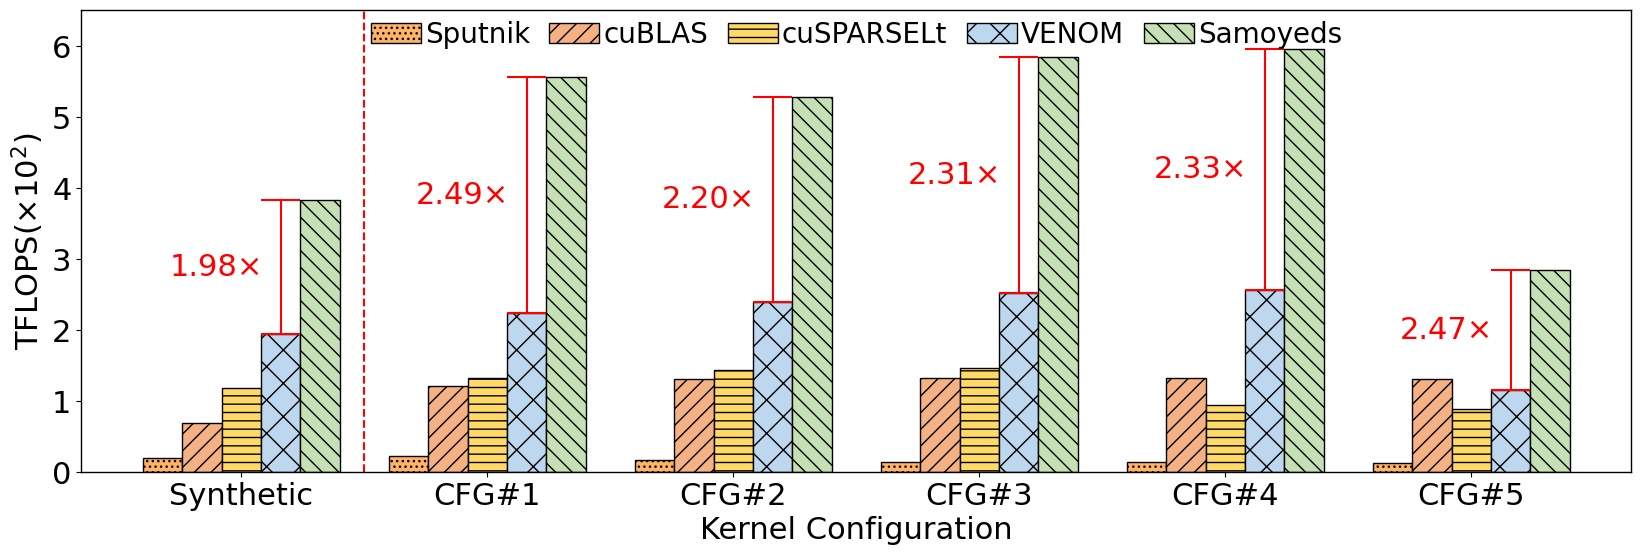

In [30]:
data_df = data_dict['NVIDIA.GeForce.RTX.4070.SUPER']
data_df['name'] = data_df[['k', 'm']].astype(str).apply('_'.join, axis=1)

def modify_name(row):
    dict = {'2048_1408': 'CFG#1',
            '2304_5760': 'CFG#2', 
            '3072_12288': 'CFG#3',
            '4096_14336': 'CFG#4', 
            '6144_16384': 'CFG#5', 
            }
    row['name'] = dict[row['name']] if row['name'] in dict else row['name']
    return row

data_df = data_df.apply(modify_name, axis=1)

column_names_without_device = ['Sputnik', 'cuBlas', 'cuSparseLtsearched', 'Venom', 'ssmm', 'name']
data_df = data_df[column_names_without_device]

name_mapping = {'Sputnik': 'Sputnik', 'cuBlas': 'cuBLAS', 'cuSparseLtsearched': 'cuSPARSELt', 'Venom': 'VENOM', 'ssmm': 'Samoyeds'}
data_df = data_df.rename(columns=name_mapping)

data_df.set_index('name', inplace=True)

order = ['CFG#1', 'CFG#2', 'CFG#3', 'CFG#4', 'CFG#5']
data_df = data_df.loc[order]

# synthetic data
new_row = pd.Series(df.iloc[0], name='Synthetic')
data_df = data_df._append(new_row)
data_df = data_df.iloc[[len(data_df)-1]]._append(data_df.iloc[:-1], ignore_index=False)

data_df = data_df/100.0

print(data_df)

# Enhancing the aesthetics of the plot with a horizontal line at y=1
fig, ax = plt.subplots(figsize=(20, 6))

# Plot data with a better color scheme and wider bars
colors = ['#FFB366', '#F4B183', '#FFD966', '#BDD7EE', '#C5E0B4']
data_df.plot(kind='bar', ax=ax, width=0.8, color=colors, edgecolor='black', rot=0, linewidth=1)

hatches = ['...', '//', '--', 'x', '\\\\']
color_to_hatch = dict(zip(colors, hatches))
for i, bar in enumerate(ax.patches):
    hex_color = mcolors.to_hex(bar.get_facecolor()).upper()
    bar.set_hatch(color_to_hatch[hex_color])

# Set labels and title with enhanced formatting
ax.set_xlabel("Kernel Configuration")
ax.set_ylabel(r'TFLOPS($\times 10^2$)')

for spine in ax.spines.values():
    spine.set_linewidth(1)

cfg_counter = 0
for name, rows in data_df.iterrows():
    patch_idx = cfg_counter + 3 * data_df.shape[0]
    
    venom_patch = ax.patches[patch_idx]
    SSMM_patch = ax.patches[patch_idx + data_df.shape[0]]
    venom = ax.patches[patch_idx].get_height()
    SSMM = ax.patches[patch_idx+1].get_height()
    
    x_center = (venom_patch.get_x() + venom_patch.get_x() + venom_patch.get_width()) / 2
    ax.hlines(SSMM_patch.get_height(), xmin=venom_patch.get_x(), xmax=venom_patch.get_x()+venom_patch.get_width(), colors='red')
    ax.hlines(venom_patch.get_height(), xmin=venom_patch.get_x(), xmax=SSMM_patch.get_x(), colors='red')
    
    text_height = 50
    total_height = SSMM_patch.get_height() - venom_patch.get_height() - text_height
    ax.vlines(x_center, ymin=venom_patch.get_height(), ymax=SSMM_patch.get_height(), colors='red')
    
    speedup = SSMM_patch.get_height() / venom_patch.get_height()
    ax.text(venom_patch.get_x()-0.18, (venom_patch.get_height() + SSMM_patch.get_height())/2, f'{speedup:.2f}\u00D7', ha='center', va='center', fontsize=22, color='red')
    
    cfg_counter += 1

ax.axvline(x=0.5, color='red', linestyle='--', linewidth=1.5)

ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1]+0.25])

legend = ax.legend(loc='upper center', ncol=5, frameon=False, handletextpad=0.15, labelspacing=0.1, fontsize=20, columnspacing=0.7, borderaxespad=0.0, handlelength=1.8)

# Show the plot
plt.show()